In [1]:
#env:ml-s7
import numpy as np
import pandas as pd
# from icecream import ic
import subprocess
import json
import os
import plotly.graph_objects as go
from matplotlib import pyplot as plt
# import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely.ops import cascaded_union, unary_union
# from shapely import geometry
# from geopy import distance
%matplotlib inline
import plotly.express as px 
from scipy import signal
from tqdm import tqdm
# from Bio import Phylo
# import ete3
import itertools
import sklearn

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_classif,  SelectKBest, chi2, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
def value_counts_list(lst):
    """
    Computes the frequency count of unique elements in a list and returns a dictionary, sorted by frequency count in
    descending order.

    Args:
    - lst (list): List of elements

    Returns:
    - dict: Dictionary with unique elements as keys and their frequency count as values, sorted by frequency count
    in descending order
    """
    value_counts = {}
    for item in lst:
        if item in value_counts:
            value_counts[item] += 1
        else:
            value_counts[item] = 1
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

## Data prep

In [3]:
def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [4]:

def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score

# # Assuming aa_array is a numpy array and mic_aa['EMB_MIC'] is a pandas Series
# def data_split(aa_array, encoded_mic):
#     # Encode the target variable
    
#     # Perform stratified train-test split
#     train_data, test_data, train_target, test_target = train_test_split(
#         aa_array,
#         encoded_mic,
#         test_size=0.1,  # 10% for testing
#         stratify=encoded_mic,  # Ensures the proportion of each class is preserved
#         random_state=42  # For reproducibility
#     )
#     return train_data, test_data, train_target, test_target

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target
# The train_data and test_data now have the same proportion of target values as the original data
# print("Train data shape:", train_data.shape)
# print("Test data shape:", test_data.shape)
# print("Train target distribution:", np.bincount(train_target))
# print("Test target distribution:", np.bincount(test_target))

def training_func(data_, target_):
    data, target = data_.copy(), target_.copy()
    if target.min() < 0:
        target += abs(target.min())
    elif target.min() > 0:
        target -= abs(target.min())
    # print(target.values)
    target_min = target.min()
    target_max = target.max()

    train_data, test_data, train_target, test_target = data_split(data, target)

    regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000)
    # regressor = xgb.XGBClassifier(objective="reg:squarederror", 
    #                          reg_lambda=0, 
    #                          min_child_weight= 4, 
    #                          learning_rate=0.05,
    #                          n_estimators=100,
    #                          max_depth=6,
    #                          colsample_bytree=0.5,
    #                          subsample=0.7,
    #                          n_jobs=4)

    regressor.fit(train_data, train_target)

    # Predict on the test data
    test_predictions = regressor.predict(test_data)

    # Calculate regression metrics
    mae = mean_absolute_error(test_target, test_predictions)
    mse = mean_squared_error(test_target, test_predictions)
    r2 = r2_score(test_target, test_predictions)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    # Function to check if predictions are within doubling dilution of the target
    def is_within_doubling_dilution(pred, target, target_min, target_max):
        _ = np.arange(target_min-1, target_max+2, 1)
        index = [i for i, x in enumerate(_) if x == target][0]
        return (_[index-1] <= pred <= _[index+1])

    # Calculate accuracy based on doubling dilution criterion
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)
    

def training_func_regression(data_, target_):
    data, target = data_.copy(), target_.copy()
    if target.min() < 0:
        target += abs(target.min())
    print(target.values)
    target_min = target.min()
    target_max = target.max()

    train_data, test_data, train_target, test_target = data_split(data, target)

    regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
    # regressor = xgb.XGBClassifier(objective="reg:squarederror", 
    #                          reg_lambda=0, 
    #                          min_child_weight= 4, 
    #                          learning_rate=0.05,
    #                          n_estimators=100,
    #                          max_depth=6,
    #                          colsample_bytree=0.5,
    #                          subsample=0.7,
    #                          n_jobs=4)

    regressor.fit(train_data, train_target)

    # Predict on the test data
    test_predictions = regressor.predict(test_data)

    # Calculate regression metrics
    mae = mean_absolute_error(test_target, test_predictions)
    mse = mean_squared_error(test_target, test_predictions)
    r2 = r2_score(test_target, test_predictions)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    # Function to check if predictions are within doubling dilution of the target
    def is_within_doubling_dilution(pred, target, target_min, target_max):
        _ = np.arange(target_min-1, target_max+2, 1)
        index = [i for i, x in enumerate(_) if x == target][0]
        return (_[index-1] <= pred <= _[index+1])

    # Calculate accuracy based on doubling dilution criterion
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)
# def training_func(data_, target_):
#     data, target = data_.copy(), target_.copy()
#     if target.min() < 0:
#         target += abs(target.min())
#     print(target.values)
#     target_min = target.min()
#     target_max = target.max()

#     train_data, test_data, train_target, test_target = data_split(data, target)

#     # Define parameter grid for cross-validation
#     param_grid = {
#         'max_depth': [10,50,100],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'n_estimators': [100, 200, 500],
#         'colsample_bytree': [0.3, 0.5, 0.7],
#         'subsample': [0.5, 0.7, 1.0]
#     }

#     # Initialize the XGBoost regressor
#     xgb_regressor = xgb.XGBClassifier(objective="reg:squarederror", random_state=0)

#     # Perform GridSearchCV to find the best parameters
#     grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, 
#                                cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
#     grid_search.fit(train_data, train_target)

#     # Use the best estimator
#     best_regressor = grid_search.best_estimator_
#     print("Best parameters found: ", grid_search.best_params_)

#     # Fit the model with the best parameters
#     best_regressor.fit(train_data, train_target)

#     # Predict on the test data
#     test_predictions = best_regressor.predict(test_data)

#     # Calculate regression metrics
#     mae = mean_absolute_error(test_target, test_predictions)
#     mse = mean_squared_error(test_target, test_predictions)
#     r2 = r2_score(test_target, test_predictions)

#     print("Mean Absolute Error (MAE):", mae)
#     print("Mean Squared Error (MSE):", mse)
#     print("R-squared (R²):", r2)

#     # Function to check if predictions are within doubling dilution of the target
#     def is_within_doubling_dilution(pred, target, target_min, target_max):
#         _ = np.arange(target_min-1, target_max+2, 1)
#         index = [i for i, x in enumerate(_) if x == target][0]
#         return (_[index-1] <= pred <= _[index+1])

#     # Calculate accuracy based on doubling dilution criterion
#     doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
#     print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

def data_split(aa_array, encoded_mic):
    # Encode the target variable
    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

In [6]:
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# def data_split(data, target, test_size=0.2, random_state=42):
#     return train_test_split(data, target, test_size=test_size, random_state=random_state)

def training_func(data_, target_, cutoff=0.5):
    data, target = data_.copy(), target_.copy()
    target = target.astype(int) 
    
    if target.min() < 0:
        target += abs(target.min())
    elif target.min() > 0:
        target -= abs(target.min())
    # print(target.values)
    
    
    target_min = target.min()
    target_max = target.max()

    train_data, test_data, train_target, test_target = data_split(data, target)

    regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000)
    regressor.fit(train_data, train_target)

    # Predict on the test data

    test_predictions = regressor.predict(test_data)

    conf_matrix = confusion_matrix(test_target, test_predictions)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Calculate regression metrics
    mae = mean_absolute_error(test_target, test_predictions)
    mse = mean_squared_error(test_target, test_predictions)
    r2 = r2_score(test_target, test_predictions)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    # Calculate AUC
    test_target_bi = (test_target >= cutoff).astype(int)
    test_predictions_bi = (test_predictions >= cutoff).astype(int)
    
    auc = roc_auc_score(test_target_bi, test_predictions_bi)
    print("AUC:", auc)

    # Calculate confusion matrix components
    conf_matrix = confusion_matrix(test_target_bi, test_predictions_bi)
    print("Confusion Matrix:\n", conf_matrix)
    tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

    # Calculate sensitivity (recall)
    sensitivity = tp / (tp + fn)
    print("Sensitivity:", sensitivity)

    # Calculate specificity
    specificity = tn / (tn + fp)
    print("Specificity:", specificity)

    # Function to check if predictions are within doubling dilution of the target
    def is_within_doubling_dilution(pred, target, target_min, target_max):
        _ = np.arange(target_min-1, target_max+2, 1)
        index = [i for i, x in enumerate(_) if x == target][0]
        return (_[index-1] <= pred <= _[index+1])
    
    # Calculate accuracy based on doubling dilution criterion
    doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
    print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)
    
    print()
    return doubling_dilution_accuracy, auc, sensitivity, specificity

# Example usage
# data_ = your_data
# target_ = your_target
# training_func(data_, target_, cutoff=0.5)


In [7]:
doubling_dilution_accuracy_, auc_, sensitivity_, specificity_, drug_names_ = [], [], [], [], []

## EMB

In [8]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
# gene_list = variants['gene'].unique()
# df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
   
# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['gene'] != 'PPE35']
# variants = variants[variants['type'] != 'synonymous_variant']
# variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

# overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
# # variants = variants[variants['drugs'].isin(['ethambutol'])]
# variants = variants[variants['gene'].isin(gene_list)]
# variants = variants[variants['sample_id'].isin(overlap)]
# variants['SNP'] = variants['gene'] + '-'+ variants['change']

# print(variants.shape)
# print(variants['sample_id'].unique().shape)


aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa['EMB_MIC'])
sample_ids = mic_aa['ENA_RUN']

doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('EMB')


/tmp/ipykernel_122980/1768204302.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_122980/1768204302.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11362/11362 [01:02<00:00, 182.95it/s]
/tmp/ipykernel_122980/3192233565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Confusion Matrix:
 [[  3  97   3   4   5   0]
 [  2 372  13   5   5   0]
 [  0 239  28  26   2   1]
 [  1  28   9  65  45   1]
 [  0   8   2  38  86   3]
 [  0   5   0   5  22  14]]
Mean Absolute Error (MAE): 0.6007036059806509
Mean Squared Error (MSE): 0.8874230430958663
R-squared (R²): 0.4833149580340593
AUC: 0.8106076227789807
Confusion Matrix:
 [[895  59]
 [ 58 125]]
Sensitivity: 0.6830601092896175
Specificity: 0.9381551362683438
Doubling Dilution Accuracy: 0.9340369393139841



In [9]:
aa_array

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [13]:
mic_series.to_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/sample_data/mic_emb.csv', index=False)
np.save('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/sample_data/aa_array_emb.npy', aa_array)

In [61]:
cutoff = 4
data, target = aa_array.copy(), mic_series.copy()
if target.min() < 0:
    target += abs(target.min())
elif target.min() > 0:
    target -= abs(target.min())
# print(target.values)
target_min = target.min()
target_max = target.max()

train_data, test_data, train_target, test_target = data_split(data, target)

regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000)
regressor.fit(train_data, train_target)

# Predict on the test data

test_predictions = regressor.predict(test_data)

# Calculate regression metrics
mae = mean_absolute_error(test_target, test_predictions)
mse = mean_squared_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Calculate AUC
test_target_bi = (test_target > cutoff).astype(int)
test_predictions_bi = (test_predictions > cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

Mean Absolute Error (MAE): 0.5866314863676341
Mean Squared Error (MSE): 0.841688654353562
R-squared (R²): 0.5099429284822544
AUC: 0.6829494281273661
Sensitivity: 0.3695652173913043
Specificity: 0.9963336388634281
Doubling Dilution Accuracy: 0.9349164467897977


In [77]:
test_predictions_bi

array([0, 0, 0, ..., 0, 0, 0])

In [75]:
print_full(test_target.values.tolist())
print_full(test_target_bi.values.tolist())

[0.0, 1.0, 3.0, 5.0, 1.0, 2.0, 1.0, 5.0, 1.0, 2.0, 0.0, 1.0, 3.0, 1.0, 2.0, 4.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 0.0, 4.0, 2.0, 1.0, 1.0, 4.0, 4.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 2.0, 0.0, 3.0, 0.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 3.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 2.0, 2.0, 4.0, 3.0, 1.0, 1.0, 4.0, 2.0, 4.0, 3.0, 0.0, 0.0, 5.0, 1.0, 4.0, 4.0, 4.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 3.0, 4.0, 1.0, 2.0, 5.0, 1.0, 1.0, 2.0, 1.0, 4.0, 3.0, 1.0, 1.0, 1.0, 2.0, 4.0, 0.0, 2.0, 1.0, 4.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 2.0, 2.0, 2.0, 4.0, 2.0, 2.0, 2.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 5.0, 2.0, 2.0, 3.0, 1.0, 4.0, 3.0, 1.0, 1.0, 3.0, 0.0, 4.0, 2.0, 3.0, 5.0, 1.0, 2.0, 3.0, 1.0, 1.0, 5.0, 2.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 4.0, 4.0, 2.0, 1.0, 3.0, 1.0, 1.0, 0.0, 4.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 5.0, 2.0, 1.0, 1.0, 5.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.0, 4.0, 1.0, 2.0,

In [76]:
print_full(test_predictions.tolist())
print_full(test_predictions_bi.tolist())

[1, 1, 3, 4, 1, 3, 1, 4, 1, 1, 1, 1, 3, 1, 1, 4, 1, 1, 2, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 4, 4, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 3, 1, 3, 3, 1, 1, 5, 1, 3, 4, 2, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 3, 3, 1, 4, 4, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 5, 1, 2, 3, 1, 4, 4, 1, 1, 3, 1, 4, 1, 0, 4, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 2, 1, 4, 4, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 2, 1, 1, 5, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 3, 1, 1, 1, 1, 2, 4, 4, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 3, 1, 4, 1, 1, 1, 1, 1, 5, 3, 1, 1, 1, 1, 1, 4, 4, 1, 4, 1, 1, 4, 2, 1, 4, 1, 4, 1, 2, 1, 1, 2, 2, 1, 1, 4, 3, 1, 1, 1, 1, 3, 1, 1, 3, 3, 4, 4, 4, 1, 2, 1, 4, 1, 1, 4, 1, 2, 1, 1, 3, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 4, 1, 4, 1, 1, 5, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 

In [ ]:
print_full(test_predictions.tolist())
print_full(test_predictions_bi.tolist())

In [122]:
drug = 'EMB'
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
# gene_list = variants['gene'].unique()
# df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa['EMB_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func_regression(aa_array, mic_series)
data, target = aa_array.copy(), mic_series.copy()
if target.min() < 0:
    target += abs(target.min())
print(target.values)
target_min = target.min()
target_max = target.max()

train_data, test_data, train_target, test_target = data_split(data, target)

# regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000)
# regressor = xgb.XGBClassifier(objective="reg:squarederror", 
#                          reg_lambda=0, 
#                          min_child_weight= 4, 
#                          learning_rate=0.05,
#                          n_estimators=100,
#                          max_depth=6,
#                          colsample_bytree=0.5,
#                          subsample=0.7,
#                          n_jobs=4)

regressor.fit(train_data, train_target)

# Predict on the test data
test_predictions = regressor.predict(test_data)

# Calculate regression metrics
mae = mean_absolute_error(test_target, test_predictions)
mse = mean_squared_error(test_target, test_predictions)
r2 = r2_score(test_target, test_predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)

# Function to check if predictions are within doubling dilution of the target
def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# Calculate accuracy based on doubling dilution criterion
doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

/tmp/ipykernel_51149/538534672.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_51149/538534672.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11310/11310 [00:55<00:00, 202.76it/s]
/tmp/ipykernel_51149/2374681304.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

[1. 2. 0. ... 1. 4. 5.]
Mean Absolute Error (MAE): 0.5685234305923961
Mean Squared Error (MSE): 0.7824933687002652
R-squared (R²): 0.5461834771041271
Doubling Dilution Accuracy: 0.9425287356321839


In [126]:
regressor.predict([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([1])

In [101]:
mic_series.value_counts()

EMB_MIC
 0.0    3968
 1.0    2957
 2.0    1493
 3.0    1366
-1.0    1117
 4.0     461
Name: count, dtype: int64

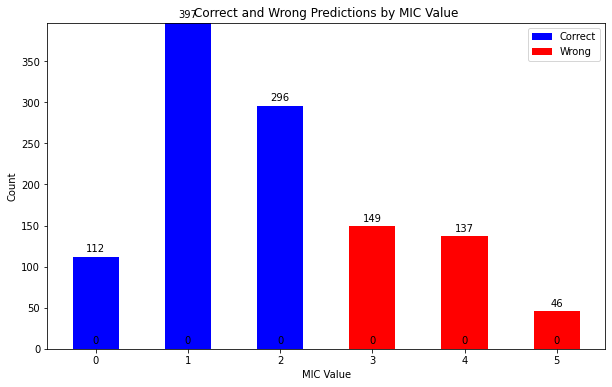

In [114]:
_wrong = []
_correct = []
_wrong345 = []
for pred, true, data_ in zip(test_predictions, test_target, test_data):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true, target_min, target_max) == False:
        _wrong.append(true)
        # if true == 3 or true == 4 or true == 5:
        _wrong345.append(data_)
    else:
        _correct.append(true)
        

# Extracting values for plotting
_wrong_count = value_counts_list(_wrong)
_correct_count = value_counts_list(_correct)
mic_values = sorted(set(_wrong_count.keys()).union(set(_correct_count.keys())))
wrong_counts = [_wrong_count.get(mic, 0) for mic in mic_values]
correct_counts = [_correct_count.get(mic, 0) for mic in mic_values]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked bar chart
bar_width = 0.5
bar1 = ax.bar(mic_values, correct_counts, bar_width, label='Correct', color='b')
bar2 = ax.bar(mic_values, wrong_counts, bar_width, bottom=correct_counts, label='Wrong', color='r')

# Adding labels
ax.set_xlabel('MIC Value')
ax.set_ylabel('Count')
ax.set_title('Correct and Wrong Predictions by MIC Value')
ax.legend()

# Adding counts on top of bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [115]:
same_x_values = {}
count = 0
for x, y in zip(_wrong345, test_target):
    # if y == -1:
    x_tuple = tuple(x)
    # x_tuple = tuple(x)
    if x_tuple not in same_x_values:
        same_x_values[x_tuple] = 1
    else:
        same_x_values[x_tuple] += 1
    # print(x)
    count += 1

In [116]:
for key, value in same_x_values.items():
    print(key, value)

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Total number of x values where y == -1: 0
Number of unique x values where y == -1: 0


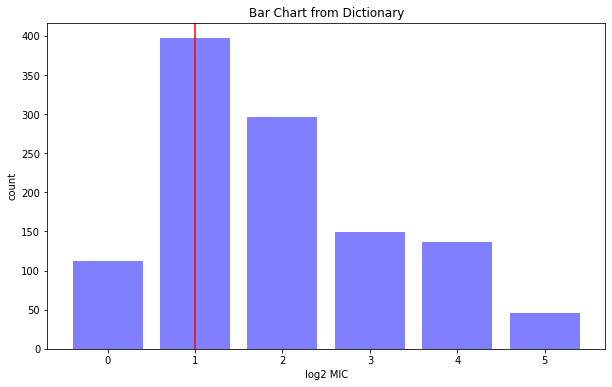

In [119]:
same_x_values = {}
count = 0
for x, y in zip(test_data, test_target):
    if y == -1:
        x_tuple = tuple(x)
        if x_tuple not in same_x_values:
            same_x_values[x_tuple] = 1
        else:
            same_x_values[x_tuple] += 1
        # print(x)
        count += 1

print(f"Total number of x values where y == -1: {count}")
print(f"Number of unique x values where y == -1: {len(same_x_values)}")

for k, v in same_x_values.items():
    print(v)
    
_t = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

# _t = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_c = []
_p = []
for data, target in zip(test_data, test_target):
    if np.array_equal(data, _t):
        _c.append(target)
        _p.append(regressor.predict([data]))

# Extracting keys and values from the dictionary
x_values = list(value_counts_list(_c).keys())
y_values = list(value_counts_list(_c).values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='blue', alpha =0.5)

# Adding labels and title
plt.ylabel('count')
plt.xlabel('log2 MIC')
plt.title('Bar Chart from Dictionary')
plt.axvline(x = regressor.predict([_t])[0], color = 'r', label = 'axvline - full height')

# Show the plot
plt.show()

## ETH

In [14]:
drug = 'ETH'
gene_list = ['ethA', 'inhA']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
# df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.25'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['{drug}_MIC'].to_list()])

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('ETH')


df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['{drug}_MIC'].to_list()])

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()
# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)

df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW'])]  # remove low quality
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['{drug}_MIC'].to_list()])
encoded_mic = mic_aa[f'{drug}_MIC'].to_list()
# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)


df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])] # remove low and medium quality
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['{drug}_MIC'].to_list()])
encoded_mic = mic_aa[f'{drug}_MIC'].to_list()
# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)


/tmp/ipykernel_122980/1145601695.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_122980/1145601695.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
100%|██████████| 11539/11539 [00:06<00:00, 1800.88it/s]
/tmp/ipykernel_122980/3192233565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

Confusion Matrix:
 [[ 17 163   2   0   0   0]
 [ 14 418   4   2   0   1]
 [  5 238  27   9   0   3]
 [  1  51  14  18   0   7]
 [  2  42   3  17   2   5]
 [  2  40   1   8   2  36]]
Mean Absolute Error (MAE): 0.8188908145580589
Mean Squared Error (MSE): 1.6802426343154246
R-squared (R²): 0.14334040450794083
AUC: 0.635091800804829
Confusion Matrix:
 [[983  11]
 [115  45]]
Sensitivity: 0.28125
Specificity: 0.9889336016096579
Doubling Dilution Accuracy: 0.8526863084922011



100%|██████████| 8419/8419 [00:04<00:00, 2005.53it/s]
/tmp/ipykernel_122980/3192233565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_122980/3192233565.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)


Confusion Matrix:
 [[ 15 115   2   1   0   0]
 [ 12 300   4   3   0   0]
 [  0 151  32   8   0   3]
 [  2  33  13  19   0   3]
 [  1  33   2   8   1   9]
 [  2  31   5   7   1  26]]
Mean Absolute Error (MAE): 0.8206650831353919
Mean Squared Error (MSE): 1.7565320665083135
R-squared (R²): 0.15081667847491542
AUC: 0.6426354526913186
Confusion Matrix:
 [[710   6]
 [ 89  37]]
Sensitivity: 0.29365079365079366
Specificity: 0.9916201117318436
Doubling Dilution Accuracy: 0.8479809976247031



100%|██████████| 8419/8419 [00:04<00:00, 1997.77it/s]
/tmp/ipykernel_122980/3192233565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_122980/3192233565.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)


Confusion Matrix:
 [[ 15 115   2   1   0   0]
 [ 12 300   4   3   0   0]
 [  0 151  32   8   0   3]
 [  2  33  13  19   0   3]
 [  1  33   2   8   1   9]
 [  2  31   5   7   1  26]]
Mean Absolute Error (MAE): 0.8206650831353919
Mean Squared Error (MSE): 1.7565320665083135
R-squared (R²): 0.15081667847491542
AUC: 0.6426354526913186
Confusion Matrix:
 [[710   6]
 [ 89  37]]
Sensitivity: 0.29365079365079366
Specificity: 0.9916201117318436
Doubling Dilution Accuracy: 0.8479809976247031



100%|██████████| 7275/7275 [00:03<00:00, 2377.49it/s]
/tmp/ipykernel_122980/3192233565.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_122980/3192233565.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)


Confusion Matrix:
 [[  4 107   5   0   0   0]
 [  3 273   2   0   1   0]
 [  1 157  11   3   1   0]
 [  0  37   8   8   0   3]
 [  1  29   4   8   2   1]
 [  0  30   5   4   0  20]]
Mean Absolute Error (MAE): 0.8626373626373627
Mean Squared Error (MSE): 1.8131868131868132
R-squared (R²): 0.09678777670837346
AUC: 0.6065705128205129
Confusion Matrix:
 [[619   5]
 [ 81  23]]
Sensitivity: 0.22115384615384615
Specificity: 0.9919871794871795
Doubling Dilution Accuracy: 0.8337912087912088



## INH

In [87]:
res_thresh = 0.1
drug = 'INH'
gene_list = ['inhA', 'katG','kasA']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
# df_emb = df[df[f'{drug}_MIC'].isin(['>1.6','0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
df_emb = df[df[f'{drug}_MIC'].isin(['>1.6','1.6','0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1.6' :
        df_emb.loc[i, f'{x}'] = '3.2'
    elif row[x] == '<=0.025':
        # df_emb.loc[i, f'{x}'] = '0.0125'
        df_emb.loc[i, f'{x}'] = '0.025'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

variants = pd.read_csv('variants_full.csv')
variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
# mic_series = np.log2(mic_aa[f'{drug}_MIC']*10)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func_regression(aa_array, mic_series)
# data, target = aa_array.copy(), mic_series.copy()
# if target.min() < 0:
#     target += abs(target.min())
# print(target.values)
# target_min = target.min()
# target_max = target.max()

doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.1)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('INH')

# train_data, test_data, train_target, test_target = data_split(data, target)

# # regressor = xgb.XGBRegressor(max_depth=100, random_state=0, n_estimators=1000)
# regressor = xgb.XGBClassifier(max_depth=100, random_state=0, n_estimators=1000)
# # regressor = xgb.XGBClassifier(objective="reg:squarederror", 
# #                          reg_lambda=0, 
# #                          min_child_weight= 4, 
# #                          learning_rate=0.05,
# #                          n_estimators=100,
# #                          max_depth=6,
# #                          colsample_bytree=0.5,
# #                          subsample=0.7,
# #                          n_jobs=4)

# regressor.fit(train_data, train_target)

# # Predict on the test data
# test_predictions = regressor.predict(test_data)

# # Calculate regression metrics
# mae = mean_absolute_error(test_target, test_predictions)
# mse = mean_squared_error(test_target, test_predictions)
# r2 = r2_score(test_target, test_predictions)

# print("Mean Absolute Error (MAE):", mae)
# print("Mean Squared Error (MSE):", mse)
# print("R-squared (R²):", r2)

# # Function to check if predictions are within doubling dilution of the target
# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     _ = np.arange(target_min-1, target_max+2, 1)
#     index = [i for i, x in enumerate(_) if x == target][0]
#     return (_[index-1] <= pred <= _[index+1])

# # Calculate accuracy based on doubling dilution criterion
# doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(test_predictions, test_target)])
# print("Doubling Dilution Accuracy:", doubling_dilution_accuracy)

/tmp/ipykernel_104761/4139215073.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.025'
/tmp/ipykernel_104761/4139215073.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '3.2'
/tmp/ipykernel_104761/4139215073.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')


Mean Absolute Error (MAE): 0.6650148662041625
Mean Squared Error (MSE): 1.442021803766105
R-squared (R²): 0.7312187525402578
AUC: 0.609437621549603
Sensitivity: 0.9308093994778068
Specificity: 0.2880658436213992
Doubling Dilution Accuracy: 0.9098116947472745


In [113]:
len(train_data[0])

932

In [ ]:
for pred, true in zip(test_predictions, test_target):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true, target_min, target_max) == False:
        _wrong.append(true)
        print('False')
        print(pred, true)
    else:
        _correct.append(true)
        print('True')
        print(pred, true)

In [ ]:
_wrong345

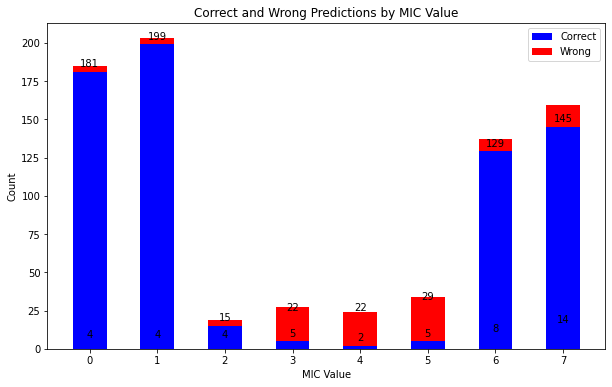

In [140]:
_wrong = []
_correct = []
_wrong345 = []
for pred, true, data_ in zip(test_predictions, test_target, test_data):
    # print('=========================')
    # print(is_within_doubling_dilution(pred, true))
    # print(pred, true)
    if is_within_doubling_dilution(pred, true, target_min, target_max) == False:
        _wrong.append(true)
        if true == 3 or true == 4 or true == 5:
            _wrong345.append(data_)
    else:
        _correct.append(true)
        

# Extracting values for plotting
_wrong_count = value_counts_list(_wrong)
_correct_count = value_counts_list(_correct)
mic_values = sorted(set(_wrong_count.keys()).union(set(_correct_count.keys())))
wrong_counts = [_wrong_count.get(mic, 0) for mic in mic_values]
correct_counts = [_correct_count.get(mic, 0) for mic in mic_values]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a stacked bar chart
bar_width = 0.5
bar1 = ax.bar(mic_values, correct_counts, bar_width, label='Correct', color='b')
bar2 = ax.bar(mic_values, wrong_counts, bar_width, bottom=correct_counts, label='Wrong', color='r')

# Adding labels
ax.set_xlabel('MIC Value')
ax.set_ylabel('Count')
ax.set_title('Correct and Wrong Predictions by MIC Value')
ax.legend()

# Adding counts on top of bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

In [142]:
same_x_values = {}
count = 0
for x, y in zip(_wrong345, test_target):
    # if y == -1:
    x_tuple = tuple(x)
    # x_tuple = tuple(x)
    if x_tuple not in same_x_values:
        same_x_values[x_tuple] = 1
    else:
        same_x_values[x_tuple] += 1
    # print(x)
    count += 1

In [ ]:
same_x_values

In [109]:
len(train_data[0])

1610

In [ ]:
for k,v in same_x_values.items():
    # if v == 234:
    print(v)
    print(k)

In [128]:
_a= [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_b =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
np.array_equal(_a, _b)

False

In [134]:
regressor.predict([_t])[0]

7

Total number of x values where y == -1: 0
Number of unique x values where y == -1: 0


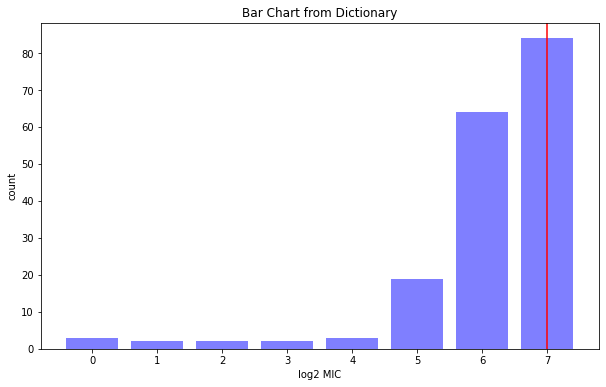

In [145]:
same_x_values = {}
count = 0
for x, y in zip(test_data, test_target):
    if y == -1:
        x_tuple = tuple(x)
        if x_tuple not in same_x_values:
            same_x_values[x_tuple] = 1
        else:
            same_x_values[x_tuple] += 1
        # print(x)
        count += 1

print(f"Total number of x values where y == -1: {count}")
print(f"Number of unique x values where y == -1: {len(same_x_values)}")

for k, v in same_x_values.items():
    print(v)
    
_t = (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

# _t = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_c = []
_p = []
for data, target in zip(test_data, test_target):
    if np.array_equal(data, _t):
        _c.append(target)
        _p.append(regressor.predict([data]))

# Extracting keys and values from the dictionary
x_values = list(value_counts_list(_c).keys())
y_values = list(value_counts_list(_c).values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.bar(x_values, y_values, color='blue', alpha =0.5)

# Adding labels and title
plt.ylabel('count')
plt.xlabel('log2 MIC')
plt.title('Bar Chart from Dictionary')
plt.axvline(x = regressor.predict([_t])[0], color = 'r', label = 'axvline - full height')

# Show the plot
plt.show()

## RIF

In [88]:
drug = 'RIF'
res_thresh = 0.5
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
# df_emb = df[df[f'{drug}_MIC'].isin(['>4','4.0', '2.0', '1.0', '0.5', '0.25', '0.12', '<=0.06'])]
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4.0', '2.0', '1.0', '0.5', '0.25', '0.12', '0.06','<=0.06'])]
# df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0','4.0', '2.0', '1.0', '0.5', '0.25', '0.12', '0.06','<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '>8':
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
        # df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

# train_data, test_data, train_target, test_target  = data_split(aa_array, encoded_mic)
mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.5)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('RIF')

/tmp/ipykernel_104761/2606652949.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.03125'
/tmp/ipykernel_104761/2606652949.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/2606652949.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '8'
/tmp/ipykernel_104761/2606652949.py:16: SettingWithCopyWarning: 
A value is trying to b

Mean Absolute Error (MAE): 0.9618736383442266
Mean Squared Error (MSE): 3.05119825708061
R-squared (R²): 0.6769902277446029
AUC: 0.6933193928227622
Sensitivity: 0.7698986975397974
Specificity: 0.6167400881057269
Doubling Dilution Accuracy: 0.7320261437908496


## RFB

In [57]:
drug = 'RFB'
res_thresh = 0.12
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df['RFB_MIC'].value_counts()

RFB_MIC
<=0.06    7210
>2        3097
2.0        515
0.12       474
1.0        355
0.25       287
0.5        210
Name: count, dtype: int64

In [89]:
drug = 'RFB'
res_thresh = 0.12
gene_list = ['rpoA', 'rpoB', 'rpoC']
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12'])]
# df_emb = df[df[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.12)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('RFB')

/tmp/ipykernel_104761/3476631840.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '4'
/tmp/ipykernel_104761/3476631840.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/3476631840.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
10

Mean Absolute Error (MAE): 0.6872340425531915
Mean Squared Error (MSE): 2.1042553191489364
R-squared (R²): 0.29575480273922783
AUC: 0.8156028368794326
Sensitivity: 0.9078014184397163
Specificity: 0.723404255319149
Doubling Dilution Accuracy: 0.8148936170212766


## MXF

In [60]:
drug = 'MXF'
gene_list = ['gyrA', 'gyrB']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]

In [62]:
df[f'{drug}_MIC'].value_counts()

MXF_MIC
0.25      4056
0.5       2674
0.12      2200
<=0.06     965
4.0        624
>4         592
1.0        573
2.0        508
Name: count, dtype: int64

In [90]:
drug = 'MXF'
gene_list = ['gyrA', 'gyrB']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>4','4.0', '2.0', '1.0', '0.5', '0.25', '0.12'])]
# df_emb = df[df[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 1)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('MXF')


/tmp/ipykernel_104761/707342392.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/707342392.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '8'
/tmp/ipykernel_104761/707342392.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
100%|

Mean Absolute Error (MAE): 0.7225274725274725
Mean Squared Error (MSE): 1.228021978021978
R-squared (R²): 0.5226220948958316
AUC: 0.5175526366210376
Sensitivity: 0.9977220956719818
Specificity: 0.037383177570093455
Doubling Dilution Accuracy: 0.9212454212454212


## KAN

In [151]:
drug = 'KAN'
df[f'{drug}_MIC'].value_counts()

KAN_MIC
2.0     5762
<=1     3541
4.0     1705
>16      740
8.0      269
16.0     111
Name: count, dtype: int64

In [91]:
drug = 'KAN'
gene_list = ['rrs', 'eis']
res_thresh = 4
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>16','16.0', '8.0', '4.0', '2.0', '<=1'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>16' :
        df_emb.loc[i, f'{x}'] = '32'
    elif row[x] == '<=1':
        df_emb.loc[i, f'{x}'] = '1.0'
        # df_emb.loc[i, f'{x}'] = '0.5'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 4)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('KAN')

/tmp/ipykernel_104761/3966471745.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '1.0'
/tmp/ipykernel_104761/3966471745.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '32'
/tmp/ipykernel_104761/3966471745.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
100

Mean Absolute Error (MAE): 0.7254237288135593
Mean Squared Error (MSE): 1.5169491525423728
R-squared (R²): 0.009199220756436755
AUC: 0.517153641357463
Sensitivity: 0.037037037037037035
Specificity: 0.997270245677889
Doubling Dilution Accuracy: 0.9144067796610169


## LEV

In [152]:
drug = 'LEV'
df[f'{drug}_MIC'].value_counts()

LEV_MIC
0.5       5656
0.25      3122
1.0        803
4.0        709
8.0        694
<=0.12     435
2.0        425
>8         317
Name: count, dtype: int64

In [92]:
drug = 'LEV'
# gene_list = ['pgi', 'fadE4', 'php', 'cyp132', 'pckA', 'rpmB1', 'pfkB', 'acg', 'ctpF', 'cyp132', 'pckA', 'pfk']
# gene_list = np.unique(variants['gene'])
gene_list = ['gyrA', 'gyrB']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.12'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
        # df_emb.loc[i, f'{x}'] = '0.06'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 1)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append('LEV')

/tmp/ipykernel_104761/2306224787.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/2306224787.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_104761/2306224787.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
1

Mean Absolute Error (MAE): 0.6145393068469992
Mean Squared Error (MSE): 1.084530853761623
R-squared (R²): 0.5622993953816455
AUC: 0.5116279069767442
Sensitivity: 1.0
Specificity: 0.023255813953488372
Doubling Dilution Accuracy: 0.9103972950126796


## LZD

In [153]:
drug = 'LZD'
df[f'{drug}_MIC'].value_counts()

LZD_MIC
0.5       5944
0.25      3316
1.0       1605
0.12       858
0.06       182
2.0         76
<=0.03      76
<=0.06      50
>2          46
4.0         21
>4          13
Name: count, dtype: int64

In [93]:
drug = 'LZD'
gene_list = ['rplC', 'rrl']
res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '0.06'])]
# df_emb = df[df[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '<=0.06'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
        # df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'     
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 1)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append(drug)

/tmp/ipykernel_104761/2699483365.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '4'
/tmp/ipykernel_104761/2699483365.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/2699483365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.0625'
/tmp/ipykernel_104761/2699483365.py:17: SettingWithCopyWarning: 
A value is trying to be

Mean Absolute Error (MAE): 0.6239316239316239
Mean Squared Error (MSE): 0.9008547008547009
R-squared (R²): -0.12211323226992299
AUC: 0.5
Sensitivity: 1.0
Specificity: 0.0
Doubling Dilution Accuracy: 0.9025641025641026


## AMI

In [149]:
drug = 'AMI'
df[f'{drug}_MIC'].value_counts()

AMI_MIC
<=0.25    7074
0.5       3510
1.0        604
>8         393
>16        286
2.0         94
16.0        42
4.0         35
8.0         32
Name: count, dtype: int64

In [94]:
drug = 'AMI'
# gene_list = np.unique(variants['gene'])
gene_list = ['rrs', 'eis']

res_thresh = 1
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.25'
        # df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 1)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append(drug)

/tmp/ipykernel_104761/2498315863.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.25'
/tmp/ipykernel_104761/2498315863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_104761/2498315863.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float')
10

Mean Absolute Error (MAE): 0.652668416447944
Mean Squared Error (MSE): 1.8810148731408574
R-squared (R²): -0.2900406312009829
AUC: 0.5048832183525892
Sensitivity: 0.028634361233480177
Specificity: 0.9811320754716981
Doubling Dilution Accuracy: 0.9020122484689413


## BDQ


In [154]:
drug = 'BDQ'
df[f'{drug}_MIC'].value_counts()

BDQ_MIC
0.03       4157
0.06       3816
<=0.015    1477
0.015      1053
0.12        790
<=0.008     420
0.25        244
0.5          65
1.0          28
>2            8
>1            5
2.0           3
Name: count, dtype: int64

In [95]:
drug = 'BDQ'
gene_list = [ 'Rv0678', 'atpE', 'pepQ']
res_thresh = 0.25

df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>1', '1.0', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1' :
        df_emb.loc[i, f'{x}'] = '2'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.25)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append(drug)

/tmp/ipykernel_104761/3946344737.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.0625'
/tmp/ipykernel_104761/3946344737.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.03125'
/tmp/ipykernel_104761/3946344737.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.015625'
/tmp/ipykernel_104761/3946344737.py:13: SettingWithCopyWarning: 
A value is try

Mean Absolute Error (MAE): 0.7611218568665378
Mean Squared Error (MSE): 1.1866537717601546
R-squared (R²): -0.24406559614675594
AUC: 0.5
Sensitivity: 1.0
Specificity: 0.0
Doubling Dilution Accuracy: 0.8936170212765957


## CFZ

In [155]:
drug = 'CFZ'
df[f'{drug}_MIC'].value_counts()

CFZ_MIC
<=0.06    3987
0.12      2746
0.06      2170
<=0.03    1408
0.25      1211
0.5        339
1.0        126
2.0         37
4.0          9
>4           8
>2           6
Name: count, dtype: int64

In [96]:
drug = 'CFZ'
gene_list = np.unique(variants['gene'])
gene_list = [ 'Rv0678', 'pepQ']
res_thresh = 0.25
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    # elif row[x] == '<=0.015':
    #     df_emb.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
# training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.25)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append(drug)


/tmp/ipykernel_104761/2688737311.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.125'
/tmp/ipykernel_104761/2688737311.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.0625'
/tmp/ipykernel_104761/2688737311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '4'
/tmp/ipykernel_104761/2688737311.py:23: SettingWithCopyWarning: 
A value is trying to be

Mean Absolute Error (MAE): 0.6934984520123839
Mean Squared Error (MSE): 0.9938080495356038
R-squared (R²): 0.0003278151122766415
AUC: 0.5
Sensitivity: 1.0
Specificity: 0.0
Doubling Dilution Accuracy: 0.9210526315789473


## DLM

In [16]:
drug = 'DLM'
res_thresh = 0.12
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>0.5', '0.5', '0.25', '0.12', '0.06', '0.03', '0,015', '<=0.015'])]

In [133]:
variants['gene'].unique()

array(['gyrA', 'mshA', 'mmpL5', 'rpsL', 'rrs', 'rpsA', 'katG', 'Rv1979c',
       'kasA', 'folC', 'thyA', 'ald', 'fprA', 'embA', 'whiB6', 'gid',
       'fgd1', 'rpoC', 'embC', 'rpoB', 'fabG1', 'fbiC', 'fbiD', 'embB',
       'gyrB', 'mmpS5', 'embR', 'ndh', 'ahpC', 'pepQ', 'Rv3083', 'clpC1',
       'aftB', 'ubiA', 'ethA', 'pncA', 'Rv3236c', 'eis', 'ccsA', 'mmpR5',
       'thyX', 'ethR', 'Rv1258c', 'rpoA', 'Rv2752c', 'tlyA', 'whiB7',
       'alr', 'inhA', 'rrl', 'rplC', 'ddn', 'atpE', 'fbiB', 'ribD',
       'fbiA', 'panD'], dtype=object)

In [97]:
drug = 'DLM'
res_thresh = 0.12
gene_list = ['fgd1','fbiA','fbiB','fbiC','fbiD','ddn']
gene_list = variants['gene'].unique()
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df[f'{drug}_MIC'].isin(['>0.5', '0.5', '0.25', '0.12', '0.06', '0.03', '0.015', '<=0.015'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>0.5' :
        df_emb.loc[i, f'{x}'] = '1'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.0078125'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'        
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
mic_series = mic_series.astype(int)
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)
training_func(aa_array, mic_series)
doubling_dilution_accuracy, auc, sensitivity, specificity = training_func(aa_array, mic_series, 0.12)
doubling_dilution_accuracy_.append(doubling_dilution_accuracy)
auc_.append(auc)
sensitivity_.append(sensitivity)
specificity_.append(specificity)
drug_names_.append(drug)

/tmp/ipykernel_104761/3224958381.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.0078125'
/tmp/ipykernel_104761/3224958381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.03125'
/tmp/ipykernel_104761/3224958381.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '0.0625'
/tmp/ipykernel_104761/3224958381.py:15: SettingWithCopyWarning: 
A value is tr

Mean Absolute Error (MAE): 0.8138479001135074
Mean Squared Error (MSE): 1.9557321225879682
R-squared (R²): -0.280464926384125
AUC: 0.6503725697467146
Sensitivity: 0.5269607843137255
Specificity: 0.773784355179704
Doubling Dilution Accuracy: 0.7843359818388195
Mean Absolute Error (MAE): 0.8138479001135074
Mean Squared Error (MSE): 1.9557321225879682
R-squared (R²): -0.280464926384125
AUC: 0.6503725697467146
Sensitivity: 0.5269607843137255
Specificity: 0.773784355179704
Doubling Dilution Accuracy: 0.7843359818388195


In [98]:
doubling_dilution_accuracy_

[0.9349164467897977,
 0.8457538994800693,
 0.9098116947472745,
 0.7320261437908496,
 0.8148936170212766,
 0.9212454212454212,
 0.9144067796610169,
 0.9103972950126796,
 0.9025641025641026,
 0.9020122484689413,
 0.8936170212765957,
 0.9210526315789473,
 0.7843359818388195]

In [104]:
drug_names_ = ['EMB','ETH','INH','RIF','RFB','MXF','KAN','LEV','LZD','AMI','BDQ','CFZ','DLM']

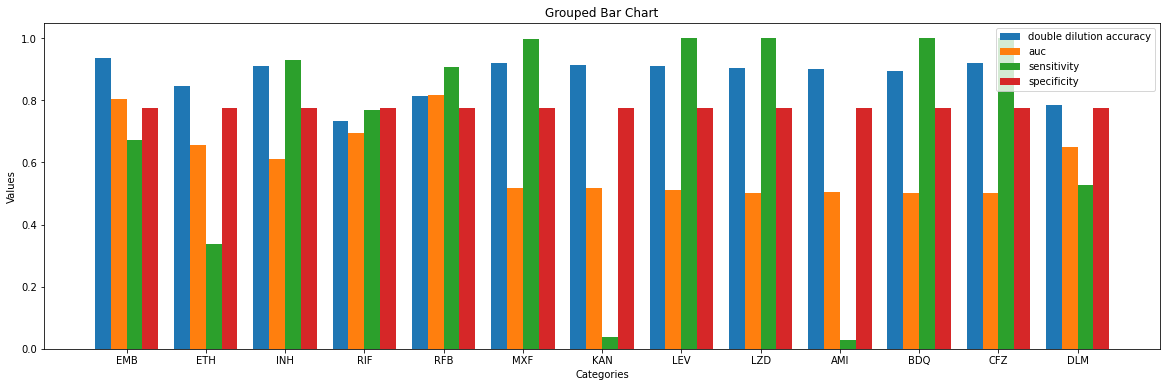

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Sample
categories = drug_names_
values1 = doubling_dilution_accuracy_
values2 = auc_
values3 = sensitivity_
values4 = specificity

# Width of the bars
bar_width = 0.2

# Positions of the bars on the x-axis
bar_positions = np.arange(len(categories))

plt.figure(figsize=(20, 6))

# Plotting each set of bars
plt.bar(bar_positions, values1, width=bar_width, label='double dilution accuracy')
plt.bar(bar_positions + bar_width, values2, width=bar_width, label='auc')
plt.bar(bar_positions + 2 * bar_width, values3, width=bar_width, label='sensitivity')
plt.bar(bar_positions + 3 * bar_width, values4, width=bar_width, label='specificity')

# Adding the category labels to the x-axis
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Grouped Bar Chart')
plt.xticks(bar_positions + 1.5 * bar_width, categories)

# Adding a legend
plt.legend()

# Display the plot
plt.show()


## To be dropped

In [113]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.25'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]


# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

variants = pd.read_csv('variants_full.csv')

# variants[~variants['drugs'].isna()]
emb_val = variants[variants['drugs']=='ethambutol']

discordance = []
discordance_values = []
_4_with_resistance = 0
_4_without_resistance = 0
to_be_dropped = []
for i, row in tqdm(mic_aa.iterrows()):
    x = 'EMB_MIC'
    # print(row[x])
    if row[x] <= 16:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('<4', row['ENA_RUN'], row[x])
            # discordance.append(row['ENA_RUN'])
            discordance_values.append(row[x])            
    if row[x] ==0.25 or row[x] ==0.125 or row[x]==0.500 or row[x]==1:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('=4', row['ENA_RUN'], row[x])
            _4_with_resistance += 1
            to_be_dropped.append(row['ENA_RUN'])
        else:
            _4_without_resistance += 1
    # elif pd.isna(row[x]):
    #     if row['ENA_RUN'] in emb_val['sample_id'].to_list():
    #         print('NaN', row['ENA_RUN'], row[x])  
    else:
        if row['ENA_RUN'] in emb_val['sample_id'].to_list():
            # print('>4', row['ENA_RUN'], row[x])
            pass
print(_4_with_resistance, '/', _4_without_resistance+ _4_with_resistance)

100%|██████████| 11445/11445 [01:03<00:00, 179.59it/s]
11445it [00:43, 263.93it/s]

231 / 5191


In [ ]:
# gene_list = variants['gene'].unique()


# All data

In [147]:
df = pd.read_csv('CRyPTIC_reuse_table_20231208.csv')
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
drug = 'ETH'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
for i, row in df_emb.iterrows():
    x = 'ETH_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
drug = 'INH'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>1.6','1.6','0.8', '0.4', '0.2', '0.1', '0.05', '<=0.025'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1.6' :
        df_emb.loc[i, f'{x}'] = '3.2'
    elif row[x] == '<=0.025':
        # df_emb.loc[i, f'{x}'] = '0.0125'
        df_emb.loc[i, f'{x}'] = '0.025'
        
drug = 'RIF'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>4','4.0', '2.0', '1.0', '0.5', '0.25', '0.12', '0.06','<=0.06'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '>8':
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
        # df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03125'
        

drug = 'MXF'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>4','4', '2', '1', '0.5', '0.25', '0.12', '<=0.06'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>4' :
        df_emb.loc[i, f'{x}'] = '8'
    elif row[x] == '<=0.06':
        df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'


drug = 'KAN'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>16','16.0', '8.0', '4.0', '2.0', '<=1'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>16' :
        df_emb.loc[i, f'{x}'] = '32'
    elif row[x] == '<=1':
        df_emb.loc[i, f'{x}'] = '1.0'
        # df_emb.loc[i, f'{x}'] = '0.5'


drug = 'LEV'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '0.25', '<=0.12'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
        # df_emb.loc[i, f'{x}'] = '0.06'


drug = 'LZD'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '0.06'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
        # df_emb.loc[i, f'{x}'] = '0.03'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'     


drug = 'AMI'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5', '<=0.25'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.25'
        # df_emb.loc[i, f'{x}'] = '0.125'


drug = 'BDQ'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>1', '1.0', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>1' :
        df_emb.loc[i, f'{x}'] = '2'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'


drug = 'CFZ'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>2','2.0', '1.0', '0.5', '0.25', '0.12', '0.06', '0.03', '<=0.015'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>2' :
        df_emb.loc[i, f'{x}'] = '4'
    # elif row[x] == '<=0.015':
    #     df_emb.loc[i, f'{x}'] = '0.0075'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'
        

drug = 'DLM'
df_emb = df_emb[df_emb[f'{drug}_MIC'].isin(['>0.5', '0.5', '0.25', '0.12', '0.06', '0.03', '0,015', '<=0.015'])]
for i, row in df_emb.iterrows():
    x = f'{drug}_MIC'
    if row[x] == '>0.5' :
        df_emb.loc[i, f'{x}'] = '1'
    elif row[x] == '<=0.015':
        df_emb.loc[i, f'{x}'] = '0.0078125'
    elif row[x] == '0.12':
        df_emb.loc[i, f'{x}'] = '0.125'        
    elif row[x] == '0.06':
        df_emb.loc[i, f'{x}'] = '0.0625'
    elif row[x] == '0.03':
        df_emb.loc[i, f'{x}'] = '0.03125'
    elif row[x] == '0.015':
        df_emb.loc[i, f'{x}'] = '0.015625'        
        
df_emb[f'{drug}_MIC'] = df_emb[f'{drug}_MIC'].astype('float') 

/tmp/ipykernel_51149/521117583.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'


In [151]:
cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])
mic_series = mic_series.astype(int)
sample_ids = mic_aa['ENA_RUN']

# training_func(aa_array, mic_series)

100%|██████████| 2058/2058 [00:13<00:00, 156.74it/s]
/tmp/ipykernel_51149/2374681304.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_51149/2374681304.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [0 2 3 4 5 6 7]

In [144]:
df_emb[['ETH_MIC','INH_MIC','RIF_MIC','ETH_MIC','INH_MIC','RIF_MIC','MXF_MIC','KAN_MIC','LEV_MIC','LZD_MIC','AMI_MIC','BDQ_MIC','CFZ_MIC','DLM_MIC']].values

array([['1.0', '0.05', '0.125', ..., '0.25', '0.125', 0.0078125],
       ['1.0', '0.05', '0.03125', ..., '0.0625', '0.125', 0.0078125],
       ['1.0', '0.05', '0.03125', ..., '0.25', '0.25', 0.0078125],
       ...,
       ['1.0', '0.05', '0.25', ..., '0.03125', '0.125', 0.03125],
       ['0.5', '0.025', '0.25', ..., '0.0625', '0.25', 0.03125],
       ['2.0', '0.05', '0.125', ..., '0.125', '0.25', 0.03125]],
      dtype=object)

In [149]:
# Remove duplicates and ensure all columns exist in the DataFrame
columns = ['ETH_MIC', 'INH_MIC', 'RIF_MIC', 'MXF_MIC', 'KAN_MIC', 'LEV_MIC', 'LZD_MIC', 'AMI_MIC', 'BDQ_MIC', 'CFZ_MIC', 'DLM_MIC']

# Check if all columns are in the DataFrame
missing_columns = [col for col in columns if col not in df_emb.columns]
if missing_columns:
    print(f"Missing columns in DataFrame: {missing_columns}")
else:
    df_emb[columns] = df_emb[columns].astype('float')

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)


100%|██████████| 2058/2058 [00:13<00:00, 154.13it/s]
/tmp/ipykernel_51149/2374681304.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
/tmp/ipykernel_51149/2374681304.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())


In [148]:
df_emb[['ETH_MIC','INH_MIC','RIF_MIC','ETH_MIC','INH_MIC','RIF_MIC','MXF_MIC','KAN_MIC','LEV_MIC','LZD_MIC','AMI_MIC','BDQ_MIC','CFZ_MIC','DLM_MIC']] = df_emb[['ETH_MIC','INH_MIC','RIF_MIC','ETH_MIC','INH_MIC','RIF_MIC','MXF_MIC','KAN_MIC','LEV_MIC','LZD_MIC','AMI_MIC','BDQ_MIC','CFZ_MIC','DLM_MIC']].astype('float') 

cryptic = df_emb
aa_array, mic_aa = data_prep(cryptic, gene_list)

encoded_mic = mic_aa[f'{drug}_MIC'].to_list()

mic_series = np.log2(mic_aa[f'{drug}_MIC'])

ValueError: Columns must be same length as key

In [150]:
df_emb

,ENA_RUN,UNIQUEID,AMI_BINARY_PHENOTYPE,BDQ_BINARY_PHENOTYPE,CFZ_BINARY_PHENOTYPE,DLM_BINARY_PHENOTYPE,EMB_BINARY_PHENOTYPE,ETH_BINARY_PHENOTYPE,INH_BINARY_PHENOTYPE,KAN_BINARY_PHENOTYPE,...,INH_PHENOTYPE_QUALITY,KAN_PHENOTYPE_QUALITY,LEV_PHENOTYPE_QUALITY,LZD_PHENOTYPE_QUALITY,MXF_PHENOTYPE_QUALITY,RIF_PHENOTYPE_QUALITY,RFB_PHENOTYPE_QUALITY,ENA_SAMPLE,VCF,REGENOTYPED_VCF
4,ERR4810495,site.02.subj.0006.lab.2014222013.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298522,00/01/08/69/10869/site.02.iso.1.subject.0006.l...,00/01/08/69/10869/site.02.iso.1.subject.0006.l...
9,ERR4810512,site.02.subj.0011.lab.2014222046.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298539,00/01/08/87/10887/site.02.iso.1.subject.0011.l...,00/01/08/87/10887/site.02.iso.1.subject.0011.l...
10,ERR4810516,site.02.subj.0012.lab.2014222053.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298543,00/01/08/91/10891/site.02.iso.1.subject.0012.l...,00/01/08/91/10891/site.02.iso.1.subject.0012.l...
11,ERR4810518,site.02.subj.0013.lab.2014222055.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298545,00/01/08/93/10893/site.02.iso.1.subject.0013.l...,00/01/08/93/10893/site.02.iso.1.subject.0013.l...
15,ERR4810526,site.02.subj.0018.lab.2014231011.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,HIGH,ERS5298553,00/01/09/01/10901/site.02.iso.1.subject.0018.l...,00/01/09/01/10901/site.02.iso.1.subject.0018.l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12256,ERR8699751,site.20.subj.SCH8516358.lab.YA00134948.iso.1,S,S,S,S,S,S,S,S,...,HIGH,LOW,LOW,HIGH,LOW,HIGH,HIGH,ERS6421651,00/02/84/22/28422/site.20.iso.1.subject.SCH851...,00/02/84/22/28422/site.20.iso.1.subject.SCH851...
12259,ERR8686595,site.20.subj.SCH8524147.lab.YA00132610.iso.1,S,S,S,S,S,S,S,R,...,HIGH,LOW,LOW,HIGH,HIGH,HIGH,HIGH,ERS6422226,00/02/54/82/25482/site.20.iso.1.subject.SCH852...,00/02/54/82/25482/site.20.iso.1.subject.SCH852...
12265,ERR8686596,site.20.subj.SCH8548249.lab.YA00132611.iso.1,S,S,S,S,I,S,S,S,...,HIGH,HIGH,LOW,LOW,LOW,LOW,HIGH,ERS6422227,00/02/54/83/25483/site.20.iso.1.subject.SCH854...,00/02/54/83/25483/site.20.iso.1.subject.SCH854...
12274,ERR8699761,site.20.subj.SCH8576461.lab.YA00134966.iso.1,S,S,S,S,S,S,S,S,...,HIGH,HIGH,HIGH,LOW,LOW,HIGH,HIGH,ERS6421661,00/02/84/32/28432/site.20.iso.1.subject.SCH857...,00/02/84/32/28432/site.20.iso.1.subject.SCH857...
